# **ECS 7001 - NN & NNLP**

## **2021/22 Lab 1: Skip-gram Model for Word2Vec**

<br>

**26th and 27th January**

There are two Word2Vec architectures for creating word embeddings: the Continuous Bag of Words (CBOW) architecture and the Skip Gram architecture . In this lab, we will obtain our own word embeddings by training a skip-gram neural network model. Some of the code for this will be supplied here but in some sections, you will be required to implement the code yourself. Hints and
tips will be provided.


The skip gram model is essentially a feedforward neural network with one hidden layer, trained to predict the context word given a target word. There are two ways to train this model: (1) using a hierarchical softmax function and/or (2) by negative sampling. In this lab, we will be training using
negative sampling. To train with negative sampling, the model is cast as a binary classification problem. The dataset would consist of positive and negative examples of the form:

Input | label
--| --
(target_word, word_in_its_context)       |  1 
(target_word, word_not_in_its_context)   |  0

created from the sentences in a corpus. The exact number of positive and negative examples will depend on the window size, and the balance ratio of positive:negative examples.  

As an example, consider the sentence: “ **The quick brown
fox jumped over the lazy dog** ”. For the target word ' **fox** ' and a window size of 2, all the positive and negative examples drawn from this sentence would be:

Input | label
--| --
(fox, the) | 0
(fox, quick) | 1
(fox, brown) | 1
(fox, jumped) | 1
(fox, over) |1
(fox, lazy) | 0
(fox, dog) | 0

The model is trained to learn to predict 1 when a word is in the context of the target word (i.e.in the window of the target word) and 0 otherwise. The model thus learns the statistics of the given corpus: the frequency with two words appear together would determine how similar they are (similarity is usually measured using cosine distance). After training, the trained hidden layer weights are the word embeddings.



### **0. Prepare the environment**

Open Google Colab or activate the virtual environment you’ve created

### **1. Downloading the Corpus**

Our training data will be comprised of 3 documents from the Gutenberg corpus. We can find this and other corpora in nltk https://www.nltk.org/book/ch02.html

In [ ]:
import nltk
import requests
requests.packages.urllib3.disable_warnings()
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('punkt')
nltk.download('gutenberg')
from nltk.corpus import gutenberg
austen = gutenberg.sents('austen-sense.txt') + gutenberg.sents('austen-emma.txt') + gutenberg.sents('austen-persuasion.txt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


**Sanity check:**

This training corpus contains 16498 sentences. The following print statement should return 16498.

In [ ]:
print(len(austen))

16498


In [ ]:
austen[0]

['[', 'Sense', 'and', 'Sensibility', 'by', 'Jane', 'Austen', '1811', ']']

### **2. Preprocessing the Training Corpus**

In this section, you will write code to remove special characters, empty strings, digits and
stopwords from the sentences and put all the words into lower cases. You might also consider removing sentences with fewer than 3 words or at least empty sentences.


**Hints:**
*   The corpus can be accessed as you would a tokenized list, a list of lists, each inner list contains all the tokens in the sentence. Eg:
\>> austen[0] =['[', 'Sense', 'and', 'Sensibility', 'by','Jane', 'Austen', '1811', ']']

*   the python <string> library contains a variable “punctuation”, a string containing all
the special characters.

*   You might want to write a function that takes the corpus as an argument and returns the preprocessed corpus as a list of lists.

 Alternatively, you can use the keras preprocessing library to preprocess the text. More information on the library can be found here:
https://keras.io/preprocessing/text/


**Sanity check:**

After preprocessing the corpus, as a sanity check, print the following line of code. If you chose removed sentences of length with fewer than 3 words, it should be about 13651. 

As a test for your preprocessing function, preprocess the sample below and print the output of your function.

## Pre-processing
To pre-process the data I have performed the following operations:-

1) Removing stop words using the NLTK library

2) Converting everything to a lower case

3) Removing the spaces using the strip method in python

4) Removing sentences with length of less than 3

Download the stopwords form NLTK

In [ ]:
from nltk import WordNetLemmatizer
import spacy 
import nltk
nltk.download('stopwords')
clean_dat = nltk.corpus.stopwords.words('english')
def preprocess_corpus(corpus):
  final_corpus = []  # a list to store final data
  for sent in corpus:
    normalized_corpus = []
    for words in sent:
      if words.isalpha() and words not in clean_dat:
        normalized_corpus.append(words)
    if len(normalized_corpus) > 3: # setting minimum sentence length to 3
      final_corpus.append(normalized_corpus)
  return final_corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


checking the length of our corpus

In [ ]:
print('The length of the pre-processed corpus is:-',len(preprocess_corpus(austen)))

The length of the pre-processed corpus is:- 13651


the lenght of our corpus is 13651 which is equal to the one provided by the professor, hence using this corpus for further problems}

In [ ]:
normalized_corpus = preprocess_corpus(austen)

In [ ]:
sample = austen[:2] + austen[100:102]
preprocessed_sample = (preprocess_corpus(sample))

print(len(sample), sample)

print(len(preprocessed_sample), preprocessed_sample)

4 [['[', 'Sense', 'and', 'Sensibility', 'by', 'Jane', 'Austen', '1811', ']'], ['CHAPTER', '1'], ['But', ',', 'then', ',', 'if', 'Mrs', '.', 'Dashwood', 'should', 'live', 'fifteen', 'years', 'we', 'shall', 'be', 'completely', 'taken', 'in', '."'], ['"', 'Fifteen', 'years', '!']]
2 [['Sense', 'Sensibility', 'Jane', 'Austen'], ['But', 'Mrs', 'Dashwood', 'live', 'fifteen', 'years', 'shall', 'completely', 'taken']]


Creating a dictionary with word and index pair

In [ ]:
xbc = [item for sublist in normalized_corpus for item in sublist]
xbc_words = list(dict.fromkeys(xbc))

xbc_dict = dict(enumerate(xbc_words))

i= 0 
print('These are the first five values of the word-index pair dictionary')
for key, value in xbc_dict.items():
  i = i+1
  if i<6:
    print(key, ':', value)

These are the first five values of the word-index pair dictionary
0 : Sense
1 : Sensibility
2 : Jane
3 : Austen
4 : The


*here **xbc_dict** is a dictionary of all the words and its corresponding index*

### **3. Creating the Corpus Vocabulary and Preparing the Data**


To prepare the data for machine learning, you will write code to prepare 3 variables:

1. \<word2idx>: a lookup table, a dictionary of (word index: word) pairs where **word index** is a unique integer assigned to every **unique word** in the corpus.
2. \<idx2word>: a dictionary of (token: token index), a reversal of \<word2idx>. 
3. \<sents_as_ids>: The input to the model cannot be text, rather, each word needs to be represented by a unique integer and each sentence an array of integers.


The incomplete code provided below is just a guide. 

### Creating funcitons for obtaining the above three variables

1) word2idx - extracting word-index pairs in a list form

2) idx2word - extracting index-word pairs in a list form

3) sentAsId - a list all the sentences in our corpus but contains index instead of words

In [ ]:
from itertools import count
import copy

# making a copy of our normalized_corpus (final preprocessed corpus)
temp_data = copy.deepcopy(normalized_corpus)

# creating a list of word-index pairs
def prepareData_idx(temp_data):
  xbc = [item for sublist in normalized_corpus for item in sublist]
  xbc_words = list(dict.fromkeys(xbc))
  xbc_dict_words = dict(enumerate(xbc_words))
  return xbc_dict_words

#creating a list of index-word pairs
def prepareData_word(temp_data):
  xbc = [item for sublist in normalized_corpus for item in sublist]
  xbc_words = list(dict.fromkeys(xbc))
  xbc_dict = dict(enumerate(xbc_words))
  xbc_dict_number = dict((k,v) for v,k in xbc_dict.items())
  return xbc_dict_number

#creating a list all the sentences in our corpus but contains index instead of words
def prepareSentsAsId(temp_data):
    for i, x in enumerate(temp_data):
        for j, a in enumerate(x):
            temp_data[i][j] = word2idx.get(a)
    return temp_data

from keras.preprocessing import text

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(temp_data)

word2idx = prepareData_word(temp_data)
idx2word = prepareData_idx(temp_data)
sentAsId = prepareSentsAsId(temp_data)

**Sanity Check**

Copy and run the following lines of code:

```
print('Number of unique words:', len(word2idx)**
```
Returns a number between 9800 and 12000, the exact number depends on your preprocessing step. 

```
print('\nSample word2idx: ', list(word2idx.items())[:10])
```

Sample word2idx:  [('sense', 0), ('sensibility', 1), ('jane', 2), ('austen', 3), ('the', 4), ('family', 5), ('dashwood', 6), ('long', 7), ('settled', 8), ('sussex', 9)]


```
print('\nSample idx2word:', list(idx2word.items())[:10])**
```

Sample idx2word: [(1, 'could'), (2, 'would'), (3, 'mr'), (4, 'mrs'), (5, 'must'), (6, 'said'), (7, 'one'), (8, 'much'), (9, 'miss'), (10, 'every')]

```
print('\nSample sents_as_id:', prepareSentsAsId(preprocessed_sample))
```

Sample sents_as_id: [[0, 1, 2, 3], [41, 72, 6, 201, 619, 35, 620, 296, 621]]



In [ ]:

print('Number of unique words:', len(word2idx))
#Returns a number between 9800 and 1200, the exact number depends on your preprocessing step.

print('\nSample word2idx: ', list(word2idx.items())[:10])
#Sample word2idx: [('sense', 0), ('sensibility', 1), ('jane', 2), ('austen', 3), ('the', 4), ('family', 5), ('dashwood', 6), ('long', 7), ('settled', 8), ('sussex', 9)]

print('\nSample idx2word:', list(idx2word.items())[:10])
#Sample idx2word: [(1, 'could'), (2, 'would'), (3, 'mr'), (4, 'mrs'), (5, 'must'), (6, 'said'), (7, 'one'), (8, 'much'), (9, 'miss'), (10, 'every')]

print('\nSample sents_as_id:', sentAsId)
#Sample sents_as_id: [[0, 1, 2, 3], [41, 72, 6, 201, 619, 35, 620, 296, 621]]


Number of unique words: 10793

Sample word2idx:  [('Sense', 0), ('Sensibility', 1), ('Jane', 2), ('Austen', 3), ('The', 4), ('family', 5), ('Dashwood', 6), ('long', 7), ('settled', 8), ('Sussex', 9)]

Sample idx2word: [(0, 'Sense'), (1, 'Sensibility'), (2, 'Jane'), (3, 'Austen'), (4, 'The'), (5, 'family'), (6, 'Dashwood'), (7, 'long'), (8, 'settled'), (9, 'Sussex')]

Sample sents_as_id: [[0, 1, 2, 3], [4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], [4, 30, 31, 11, 33, 34, 20, 36, 37, 18, 39, 40, 41, 42, 43, 44], [45, 46, 47, 48, 39, 50, 51, 52, 53, 54, 55, 56, 57, 58, 5, 60, 61, 62, 6, 64, 65, 14, 11, 68, 69, 70], [71, 72, 60, 74, 75, 76, 77, 78, 79, 80], [4, 41, 83, 61, 85, 62, 6, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 37, 100, 101, 102, 75, 104, 105, 106], [107, 108, 109, 61, 62, 6, 113, 114, 115, 116, 117, 118], [4, 114, 121, 21, 123, 34, 125, 126, 127, 128, 12, 130, 131, 132, 37], [107, 109, 136, 47, 138, 139, 104, 141], [142, 

After you have created the three variables, set the <vocab_size> and <embed_size> variables with the following commands:

In [ ]:
from keras.preprocessing import text
VOCAB_SIZE = len(word2idx)
EMBED_SIZE = 100 # We are creating 100D embeddings.
print('Vocabulary Size:', VOCAB_SIZE)
print('Vocabulary Sample:', list(word2idx.items())[:10])

Vocabulary Size: 10793
Vocabulary Sample: [('Sense', 0), ('Sensibility', 1), ('Jane', 2), ('Austen', 3), ('The', 4), ('family', 5), ('Dashwood', 6), ('long', 7), ('settled', 8), ('Sussex', 9)]


In [ ]:
print('Number of unique words:', len(word2idx))

Number of unique words: 10793


### **4. Generating training instances**


In this section we would generate the training examples of the format shown in introduction using the keras skip-gram generator https://keras.io/preprocessing/sequence/ 

**Sanity Check:**

To view the skip_grams for the first sentence in the training data, run the line of code that follows. The output should look like:

(austen (3), sensibility (1)) -> 1

(austen (3), jane (2)) -> 1

(jane (2), sensibility (1)) -> 1

(jane (2), walked (2639)) -> 0

(jane (2), partridge (7948)) -> 0

(sensibility (1), austen (3)) -> 1

(sensibility (1), beneficial (5587)) -> 0

(sensibility (1), jane (2)) -> 1

(sensibility (1), dreamt (8308)) -> 0

(austen (3), perception (6543)) -> 0

(jane (2), austen (3)) -> 1

(austen (3), imposing (8622)) -> 0


In [ ]:
from keras.preprocessing.sequence import skipgrams

skip_grams = [skipgrams(wordid, vocabulary_size=VOCAB_SIZE, shuffle=False) for wordid in sentAsId]

pairs, labels = skip_grams[0][0], skip_grams[0][1]

for i in range(len(pairs)):
	print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
			idx2word[pairs[i][0]], pairs[i][0], 
			idx2word[pairs[i][1]], pairs[i][1], 
			labels[i]))

(Sensibility (1), Jane (2)) -> 1
(Sensibility (1), Austen (3)) -> 1
(Jane (2), Sensibility (1)) -> 1
(Jane (2), Austen (3)) -> 1
(Austen (3), Sensibility (1)) -> 1
(Austen (3), Jane (2)) -> 1
(Austen (3), dowager (10466)) -> 0
(Austen (3), Little (2424)) -> 0
(Sensibility (1), rises (3144)) -> 0
(Sensibility (1), included (2435)) -> 0
(Jane (2), Just (5675)) -> 0
(Jane (2), Islands (9865)) -> 0


### **5. Building the Skip-gram Neural Network Architecture**

In this section we would be building the skip-gram neural network architecture using the Keras Functional API and the Sequential model introduced in the previous lab. https://keras.io/getting-started/functional-api-guide/ 

In [ ]:
from keras.layers import Dot, Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils.vis_utils import plot_model


The skip-gram model is two input one output feedforward neural network with one hidden layer and this will be built over a series of steps.

####**A. The first step is to initialize and transform the first input using the following lines of code:**

In [ ]:
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
target_word = Input((1,), dtype='int32')


# feed the words into the model using the Keras <Embedding> layer. This is the hidden layer 
# from whose weights we will get the word embeddings.
target_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='target_embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=1)(target_word)


# at this point, the input would of the shape (num_inputs x 1 x embed_size) and has to be flattened 
# or reshaped into a (num_inputs x embed_size) tensor.
target_input = Reshape((EMBED_SIZE, ))(target_embedding)

####**B. Write similar code for the ‘context_word’ input.**

In [ ]:

context_word = Input((1,), dtype='int32')


# feed the words into the model using the Keras <Embedding> layer. This is the hidden layer 
# from whose weights we will get the word embeddings.
context_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='conext_embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=1)(context_word)


# at this point, the input would of the shape (num_inputs x 1 x embed_size) and has to be flattened 
# or reshaped into a (num_inputs x embed_size) tensor.
context_input = Reshape((EMBED_SIZE, ))(context_embedding)

####**C. Merge the inputs.**

Recall, each training instance is a (target_word, context_word) combination. Since we are trying to learn the degree of closeness between the two words, the model will compute the cosine distance between the two inputs using the <Dot> layer. https://keras.io/layers/merge/, hence fusing the two inputs into one.


In [ ]:
merged_inputs = Dot(axes=-1, normalize=False)([target_input, context_input])

####**D. The Output Layer**

Pass the merged inputs (now a vector with a single number the cosine distance between the two input vectors for each word) into a sigmoid activated neuron. The output of this layer is the output of the model.

**Hint**: Use the <Dense> layer ( https://keras.io/layers/core/ ), with a ‘sigmoid’ activation function.

In [ ]:
# your code for the output layer goes here
import tensorflow as tf
label = Dense(1, activation='sigmoid')(merged_inputs)

####**E. Initialize the model:**

In [ ]:
# label is the output of step D.
model = Model(inputs=[target_word, context_word], outputs=[label])  

####**F. Compile the model using the <model.compile> command.** Use Loss = ‘mean_squared_error’, optimizer = ‘rmsprop’.

In [ ]:
# your code here
model.compile(loss = 'mean_squared_error', optimizer = 'rmsprop')

**Sanity check:**

Visualize the model and the model summary by running the following lines of code. 
view the model summary

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 target_embed_layer (Embedding)  (None, 1, 100)      1079300     ['input_3[0][0]']                
                                                                                                  
 conext_embed_layer (Embedding)  (None, 1, 100)      1079300     ['input_4[0][0]']                
                                                                                            

####**G. Plot the model using ```vis utils```.**

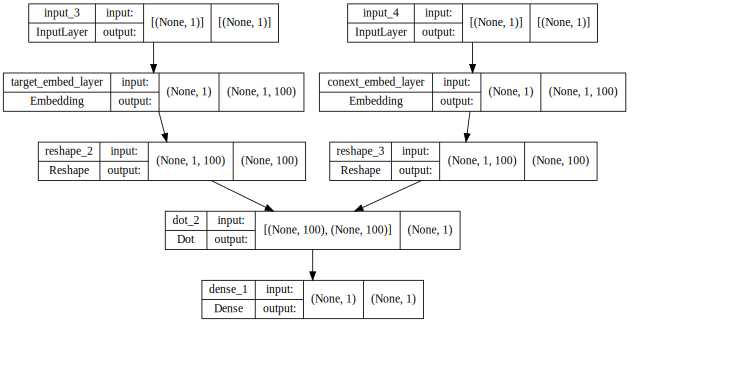

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  


###**6.Training the Model**

Run the following block of code to train the model for 5 epochs:

In [ ]:
import numpy as np

NUM_EPOCHS = 5

for epoch in range(1, NUM_EPOCHS+1):
    epoch_loss = 0
    for i, sent_examples in enumerate(skip_grams):
        target_wds = np.array([pair[0] for pair in sent_examples[0]], dtype='int32')
        context_wds = np.array([pair[1] for pair in sent_examples[0]], dtype='int32')
        labels = np.array(sent_examples[1], dtype='int32')
        X = [target_wds, context_wds]
        Y = labels
        if i % 5000 == 0: 
        	print('Processed %d sentences' %i)
        epoch_loss += model.train_on_batch(X, Y)
    print('Processed all %d sentences' %i)
    print('Epoch:', epoch, 'Loss:', epoch_loss, '\n')



Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13650 sentences
Epoch: 1 Loss: 2264.0329536153004 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13650 sentences
Epoch: 2 Loss: 1850.2228438006714 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13650 sentences
Epoch: 3 Loss: 1772.6664474601857 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13650 sentences
Epoch: 4 Loss: 1727.2373684805352 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13650 sentences
Epoch: 5 Loss: 1696.9913099966943 



The training takes about 10 minutes to run.

<br>

In the introduction, we outlined two approaches to training using the skipgram architecture. In this tutorial, we implemented the negative sampling training approach. While waiting for the training to complete, read this article http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/. It contains the skipgram model with softmax training. 

<br>

After reading the article, answer the following questions:  
●	What would the inputs and outputs to the model be?

●	How would you use the Keras framework to create this architecture?

●	What are the reasons this training approach is 
considered inefficient?


###**7. Getting the Word Embeddings**

The word embeddings are the weights of the target word embedding layer.


In [ ]:
word_embeddings = model.get_layer('target_embed_layer').get_weights()[0] 

# should return (VOCAB_SIZE, EMBED_SIZE)
print(word_embeddings.shape)

(10793, 100)


Print out a few words and their embeddings using the next block of code. Your output may not be exactly as above but the command should print 10 words and their respective vectors.

In [ ]:
from pandas import DataFrame
import pandas as pd
from IPython.display import display
pd.options.display.max_columns = 10
display(DataFrame(word_embeddings, index=idx2word.values()).head(10))

,0,1,2,3,4,...,95,96,97,98,99
Sense,-0.012889,-0.014781,0.003798,-0.017777,-0.001310,...,0.013198,0.015331,0.001187,0.004664,-0.003040
Sensibility,-0.016206,0.019851,0.006646,-0.030996,-0.025132,...,-0.012692,-0.012216,0.005904,-0.005677,0.005312
Jane,-0.008188,-0.003442,0.016382,-0.018266,-0.017170,...,0.084458,0.022490,-0.018873,-0.046774,0.015085
Austen,0.007210,0.027767,0.003212,-0.016938,-0.030487,...,-0.008006,-0.007678,-0.000656,0.002114,-0.011942
The,-0.005701,-0.209884,-0.084247,0.080748,0.098198,...,-0.060496,0.134988,-0.161182,-0.089144,0.006232
family,-0.111032,0.086373,-0.104481,-0.066156,-0.102111,...,-0.012154,0.116921,0.051188,0.055400,0.026335
Dashwood,0.129675,-0.075833,0.084883,-0.110967,0.042926,...,-0.113949,0.016255,-0.038229,-0.050746,-0.077659
long,-0.056391,-0.027358,0.028103,-0.095403,0.028012,...,0.160413,0.029418,-0.060204,0.053006,-0.042897
settled,-0.034872,-0.004042,-0.000941,0.012048,-0.027108,...,0.050069,0.096545,0.040370,-0.023208,-0.008482
Sussex,-0.019787,0.002034,0.027959,-0.003782,-0.000654,...,-0.000760,-0.018197,-0.034574,-0.036219,0.001555


###**8.  Measuring Similarity Between Word Pairs**



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(word_embeddings)

# should print(VOCAB_SIZE, VOCAB_SIZE)
print(similarity_matrix.shape)   

(10793, 10793)


###**9. Exploring and Visualizing your Word Embeddings using t-SNE**

**A.	Get the most similar words to the search items in the list below**

search_terms = ['family', 'love', 'equality', 'wisdom', 'justice',  'humour', 'rejection']


**Sanity check:**
The similar words obtained would depend on your training but the above command should print a dictionary. Each key is a search term and each value is a list of the 5 words the model predicts to be most similar to the key word. 


In [ ]:
search_terms = ['think', 'thought', 'friend', 'love', 'disdain']

# write code to get the 5 words most similar to the words in search_terms
similar_words = {search_term: [idx2word[idx] for idx in similarity_matrix[word2idx[search_term]].argsort()[0:5]]
                    for search_term in search_terms}

print(similar_words)

{'think': ['cheeks', 'proceeded', 'shocked', 'excuse', 'shrubbery'], 'thought': ['walked', 'sympathised', 'farmer', 'expense', 'accepts'], 'friend': ['Absurd', 'finish', 'declining', 'accordingly', 'sooner'], 'love': ['remnant', 'Their', 'suspicions', 'enclosed', 'distinct'], 'disdain': ['Mr', 'might', 'going', 'remember', 'Woodhouse']}


**B. Plot the words in the dictionary above using t-SN**E 

1.   List item

1.   List item
2.   List item


2.   List item

https://lvdmaaten.github.io/tsne/ 

Plot 50 of the word embeddings using the code snippets below:














/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


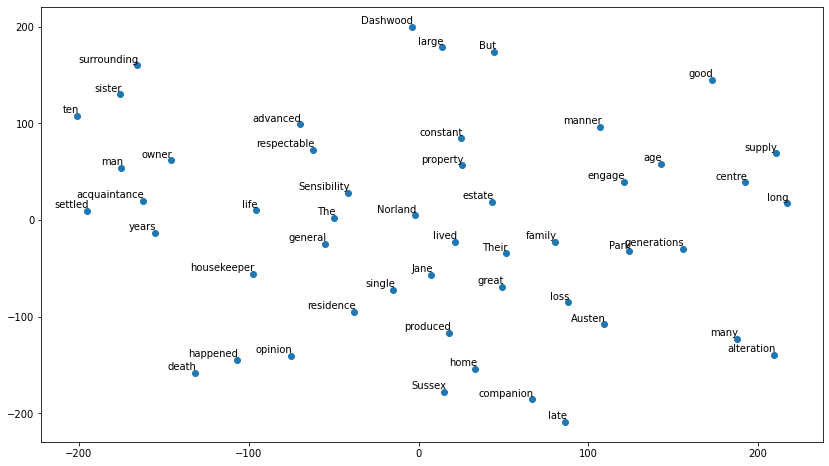

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50 

T = tsne.fit_transform(word_embeddings[:plot_only, :])
labels = [idx2word[i+1] for i in range(plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')                      	                        



**10. Resources used**

http://jalammar.github.io/illustrated-word2vec/
https://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/ 
https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa 
https://adventuresinmachinelearning.com/word2vec-keras-tutorial/ 
https://www.tensorflow.org/tutorials/representation/word2vec#the_skip-gram_model 
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py 

